## Description

This project is to analyze twitter comments and classify them into categories. The data source is from [Twitter and Reddit Sentimental analysis Dataset](https://www.kaggle.com/datasets/cosmos98/twitter-and-reddit-sentimental-analysis-dataset/data), under license 'CC BY-NC-SA 4.0 DEED'.

We are going to build the model with pre-trained model.

According to the description of dataset, we have the following explanation for category column:

- 0 Indicating it is a Neutral Tweet/Comment
- 1 Indicating a Postive Sentiment
- -1 Indicating a Negative Tweet/Comment

Members:

- **Qianfan Cheng: 101415827**
- **Sut Ring Ja K P: 101468803**

In [ ]:
!pip install google.colab

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


### 1. import necessary libraries

In [3]:
import re
import string
from typing import Any
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from transformers import BertConfig
from transformers import BertTokenizerFast, TFBertForSequenceClassification
import nltk
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [4]:
import re
import string
from typing import Any
import pandas as pd
import numpy as np
from nltk.corpus import stopwords
from sklearn.model_selection import train_test_split
import tensorflow as tf


class TextPreprocessing:

    def __init__(self, df: pd.DataFrame = None):
        self._dataset = df
        self.train_dataset = None
        self.test_dataset = None
        self.val_dataset = None
        self.labels2id = {'Positive': 1, 'Neutral': 0, 'Negative': 2}
        self.id2labels = {1: 'Positive', 0: 'Neutral', 2: 'Negative'}

    @staticmethod
    def text_cleaning(text: str) -> str:
        """
        Clean the text using NLP and regular expressions
        :param text: str, uncleaned text str
        :return str:
        """
        # remove hyper links
        text = re.sub(r'https?://\S+|www\.\S+', 'URL', text)
        # remove HTML tags
        text = re.sub(r'<.*?>', '', text)
        # exclude characters that are not in the printable set
        text = ''.join([char for char in text if char in string.printable])
        # replace Twitter-like handles (starting with '@') with the string 'USER'
        text = re.sub(r'@\S+', 'USER', text)
        # remove punctuation from the text
        table = str.maketrans('', '', string.punctuation)
        text = text.translate(table)
        # remove stopwords
        text = ' '.join([
            word for word in text.split()
            if word not in stopwords.words("english")
        ])

        return text

    @property
    def dataset(self) -> pd.DataFrame:
        return self._dataset

    @dataset.setter
    def dataset(self, df: pd.DataFrame) -> None:
        self._dataset = df

    def drop_rows(self, cols: tuple[str]) -> None:
        """
        Drop null rows and duplicated rows
        :return:
        """
        if self.dataset.duplicated().sum() > 0:
            self.dataset.drop_duplicates(inplace=True)
        if cols:
            self.dataset.dropna(subset=list(cols), inplace=True)

    def convert_category_to_int(self) -> None:
        """
        convert category datatype into int8
        :return:
        """
        if self.dataset.category.isnull().sum() == 0:
            self.dataset['category'] = self.dataset['category'].astype(np.int8)

    def encode_labels(self) -> None:
        """
        map labels from str to int
        :return:
        """
        self.dataset['category'] = self.dataset['category'].map(self.labels2id)

    def update_label_values(self) -> None:
        """
        update label values from -1, 0, 1 to 0, 1, 2
        :return:
        """
        self.dataset['category'] = self.dataset.category.apply(
            lambda x: 2 if x == -1 else x)

    def text_processing(self, cols=None) -> None:
        """
        clean text column
        :param cols: list, columns to apply text processing
        :return:
        """
        self.dataset[cols] = self.dataset[cols].apply(
            TextPreprocessing.text_cleaning)

    def create_text_length(self, col: str = None) -> None:
        """
        create a text_length feature
        :param col: str, column name
        :return:
        """
        self.dataset['text_length'] = self.dataset[col].apply(len)

    def data_preprocessing(self,
                           tokenizer: Any,
                           batch_size: int = 32,
                           max_length: int = 10000) -> tuple:
        """
        tokenize the text to make them ready to pretrained model
        :param batch_size: batch size
        :param max_length: int
        :param tokenizer: Any
        :return:
        """
        # split dataset into training and validation datasets
        self.train_dataset, self.test_dataset = train_test_split(
            self.dataset, test_size=0.1, random_state=100, shuffle=True)
        self.train_dataset, self.val_dataset = train_test_split(
            self.train_dataset, test_size=0.1, random_state=100, shuffle=True)

        # tokenize text
        tokenized_train = tokenizer(self.train_dataset.clean_text.to_list(),
                                    padding=True,
                                    truncation=True,
                                    return_tensors='tf',
                                    max_length=max_length)
        tokenized_test = tokenizer(self.test_dataset.clean_text.to_list(),
                                   padding=True,
                                   truncation=True,
                                   return_tensors='tf',
                                   max_length=max_length)
        tokenized_val = tokenizer(self.val_dataset.clean_text.to_list(),
                                  padding=True,
                                  truncation=True,
                                  return_tensors='tf',
                                  max_length=max_length)

        # Convert tokenized data and labels to TensorFlow Dataset
        # batch them and shuffle the training dataset
        tensor_train_ds = (tf.data.Dataset.from_tensor_slices(({
            'input_ids': tokenized_train['input_ids'],
            'attention_mask': tokenized_train['attention_mask'],
            'token_type_ids': tokenized_train['token_type_ids'],
        }, self.train_dataset.category.values)).batch(batch_size).shuffle(
            len(self.train_dataset)))
        tensor_test_ds = (tf.data.Dataset.from_tensor_slices(({
            'input_ids': tokenized_test['input_ids'],
            'attention_mask': tokenized_test['attention_mask'],
            'token_type_ids': tokenized_test['token_type_ids'],
        }, self.test_dataset.category.values)).batch(batch_size))
        tensor_val_ds = (tf.data.Dataset.from_tensor_slices(({
            'input_ids': tokenized_val['input_ids'],
            'attention_mask': tokenized_val['attention_mask'],
            'token_type_ids': tokenized_val['token_type_ids'],
        }, self.val_dataset.category.values)).batch(batch_size))

        # Print the dataset
        # for features, label in tensor_train_ds:
        #     print("Input IDs:", features['input_ids'].numpy(), "Label:", label.numpy())

        return tensor_train_ds, tensor_val_ds, tensor_test_ds

    @staticmethod
    def prepare_predict_inputs(sentences,
                               tokenizer: Any,
                               batch_size: int = 32,
                               max_length: int = 10000) -> tf.data.Dataset:
        """
        prepare the input sentences for the prediction of custom model
        :param sentences: a list of sentences as input
        :param tokenizer: tokenizer to encode the sentences
        :param batch_size: batch_size
        :param max_length:
        :return:
        """
        tokenized_inputs = tokenizer(sentences,
                                     padding=True,
                                     truncation=True,
                                     return_tensors="tf",
                                     max_length=max_length)
        batched_input = tf.data.Dataset.from_tensor_slices({
            'input_ids': tokenized_inputs['input_ids'],
            'attention_mask': tokenized_inputs['attention_mask'],
            'token_type_ids': tokenized_inputs['token_type_ids'],
        }).batch(batch_size=batch_size)

        return batched_input


In [6]:
from typing import Any
import tensorflow as tf
from tensorflow.keras import layers
from tensorflow import keras


class PrintEpochProgress(keras.callbacks.Callback):

    def on_epoch_end(self, epoch, logs=None):
        """
        print info at the end of each epoch
        """
        print('\nEpoch:', epoch + 1, ' Loss:', logs['loss'])


class EarlyStoppingAtMinLoss(keras.callbacks.EarlyStopping):
    """
    Early stop when loss does not improve over epochs
    """

    def __init__(self, min_delta=0, patience=0, **kwargs):
        super(EarlyStoppingAtMinLoss, self).__init__(**kwargs)
        self.min_delta = min_delta
        self.patience = patience
        self.wait = 0
        self.stopped_epoch = 0
        self.best = None

    def on_epoch_end(self, epoch, logs=None):
        current = logs.get(self.monitor)
        if current is None:
            raise ValueError(
                f"Early stopping conditioned on metric `{self.monitor}` which is not available."
            )

        if self.best is None or current < self.best - self.min_delta:
            self.best = current
            self.wait = 0
        else:
            self.wait += 1
            if self.wait >= self.patience:
                self.stopped_epoch = epoch
                self.model.stop_training = True
                self.model.stopped_epoch = epoch
                self.model.best_epoch = epoch - self.patience


class CustomCheckpoint(keras.callbacks.ModelCheckpoint):

    def __init__(self, model_prefix='model', **kwargs):
        super(CustomCheckpoint, self).__init__(**kwargs)
        self.current_epoch = None
        self.wait = None
        self.model_prefix = model_prefix

    def on_epoch_end(self, epoch, logs=None):
        logs = logs or {}
        if self.epochs_since_last_save == 0:
            return

        current = logs.get(self.monitor)
        if current is None:
            raise ValueError(
                f"ModelCheckpoint conditioned on metric `{self.monitor}` which is not available."
            )

        if self.monitor_op(current, self.best):
            self.best = current
            self.wait = 0

            # Customize the checkpoint file name based on epoch and validation loss
            filepath = self.filepath.format(epoch=epoch + 1, **logs)
            if self.save_best_only:
                self.best = current
                if self.verbose > 0:
                    print(f"\nEpoch {epoch + 1}: {self.monitor} "
                          f"improved from {self.best} to {current}, "
                          f"saving model to {filepath}")
                if self.save_weights_only:
                    self.model.save_weights(filepath, overwrite=True)
            else:
                if self.verbose > 0:
                    print(f"\nEpoch {epoch + 1}: saving model to {filepath}")
                if self.save_weights_only:
                    self.model.save_weights(filepath, overwrite=True)
            self.current_epoch = epoch + 1


class SentimentAnalysisModel(keras.Model):
    """
    Build a custom model by adding a classification head on top of the pretrained transformer.
    """

    def __init__(self,
                 pretrained_model,
                 units: int = 1,
                 remove_last_layer=True,
                 **kwargs):
        super(SentimentAnalysisModel, self).__init__(**kwargs)
        if remove_last_layer:
            self.pretrained_model = keras.Sequential(
                pretrained_model.layers[:-2])
        else:
            self.pretrained_model = pretrained_model

        # Additional layers: LSTM and BatchNormalization
        # self.lstm_layer = layers.LSTM(128, return_sequences=True)
        self.lstm_layer = layers.LSTM(128)
        self.batch_norm1 = layers.BatchNormalization()
        self.drop_1 = layers.Dropout(0.25)
        self.lstm_layer2 = layers.Bidirectional(layers.LSTM(64))
        self.batch_norm2 = layers.BatchNormalization()
        self.drop_2 = layers.Dropout(0.25)
        self.lstm_layer3 = layers.LSTM(32, activation='relu')
        self.batch_norm3 = layers.BatchNormalization()
        self.drop_3 = layers.Dropout(0.25)
        # Flatten the output to be compatible with the dense layers
        self.flatten = layers.Flatten()

        self.dense_out = layers.Dense(units, activation='softmax')

    def call(self,
             inputs: Any,
             training: bool = False,
             mask: Any = None) -> Any:
        # Forward pass through the pretrained BERT model
        outputs = self.pretrained_model(inputs, training=training)

        # Extract logits from the output
        logits = outputs.pooler_output
        # Extract the relevant tensor (you may choose 'last_hidden_state' or 'pooler_output')
        # relevant_tensor = outputs.last_hidden_state  # or outputs.pooler_output

        # Pass logits through additional layers
        # additional_logits = self.additional_layers(logits)
        # Apply LSTM and BatchNormalization layers
        x = self.lstm_layer(tf.expand_dims(logits, axis=1))
        x = self.batch_norm1(x)
        x = self.drop_1(x, training=training)
        x = self.lstm_layer2(tf.expand_dims(x, axis=1))
        x = self.batch_norm2(x)
        x = self.drop_2(x, training=training)
        x = self.lstm_layer3(tf.expand_dims(x, axis=1))
        x = self.batch_norm3(x)
        x = self.drop_3(x, training=training)
        x = self.flatten(x)

        return self.dense_out(x)

    def get_config(self):
        # Serialize the configuration of the model
        base_config = super(SentimentAnalysisModel, self).get_config()
        return {'units': self.dense_out.units, **base_config}

    @classmethod
    def from_config(cls, config):
        # Create a new instance of the model using the provided configuration
        return cls(**config)


class SentimentAnalysisBaseModel(keras.Model):
    """
    Build a base model on top of the pretrained transformer.
    """

    def __init__(self,
                 pretrained_model,
                 units: int = 1,
                 remove_last_layer=True,
                 **kwargs):
        super(SentimentAnalysisBaseModel, self).__init__(**kwargs)
        if remove_last_layer:
            self.pretrained_model = keras.Sequential(
                pretrained_model.layers[:-2])
        else:
            self.pretrained_model = pretrained_model

        # Additional layers: LSTM and BatchNormalization
        # self.lstm_layer = layers.LSTM(128, return_sequences=True)
        self.lstm_layer = layers.Dense(128)
        self.batch_norm1 = layers.BatchNormalization()
        self.drop_1 = layers.Dropout(0.25)

        self.dense_out = layers.Dense(units, activation='softmax')

    def call(self,
             inputs: Any,
             training: bool = False,
             mask: Any = None) -> Any:
        # Forward pass through the pretrained BERT model
        outputs = self.pretrained_model(inputs, training=training)

        # Extract logits from the output
        logits = outputs.pooler_output
        # Extract the relevant tensor (you may choose 'last_hidden_state' or 'pooler_output')
        # relevant_tensor = outputs.last_hidden_state  # or outputs.pooler_output

        # Pass logits through additional layers
        # additional_logits = self.additional_layers(logits)
        # Apply LSTM and BatchNormalization layers
        x = self.lstm_layer(tf.expand_dims(logits, axis=1))
        x = self.batch_norm1(x)
        x = self.drop_1(x, training=training)

        return self.dense_out(x)

    def get_config(self):
        # Serialize the configuration of the model
        base_config = super(SentimentAnalysisBaseModel, self).get_config()
        return {'units': self.dense_out.units, **base_config}

    @classmethod
    def from_config(cls, config):
        # Create a new instance of the model using the provided configuration
        return cls(**config)


In [7]:
from typing import Any
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix
import numpy as np


class PlotDiagram:

    @staticmethod
    def display_training_loss(history: Any = None) -> None:
        """
        display the training loss diagram (learning curve)
        :param history:
        :return:
        """
        plt.plot(history.history['loss'])
        plt.plot(history.history['val_loss'])
        plt.title('model_loss')
        plt.ylabel('loss')
        plt.xlabel('epoch')
        plt.legend(['train', 'val'], loc='upper left')
        plt.show()

    @staticmethod
    def display_training_accuracy(history: Any = None) -> None:
        """
        display the training accuracy diagram (learning curve)
        :param history:
        :return:
        """
        plt.plot(history.history['accuracy'])
        plt.plot(history.history['val_accuracy'])

        plt.title('model_accuracy')
        plt.ylabel('accuracy')
        plt.xlabel('epoch')
        plt.legend(['train', 'val'], loc='upper left')
        plt.show()

    @staticmethod
    def display_test_predictions(y_test,
                                 y_test_hat,
                                 title='Test Predictions') -> None:
        """
        Plot the test prediction
        :param y_test:
        :param y_test_hat:
        :param title:
        :return:
        """
        plt.plot(y_test, label='True Values', marker='.')
        plt.plot(y_test_hat, label='Predicted Values', marker='.')
        plt.title(title)
        plt.xlabel('Time Steps')
        plt.ylabel('Original Values')  # Adjust based on your data scaling
        plt.legend()
        plt.show()

    @staticmethod
    def display_confusion_matrix(y_test,
                                 y_test_hat,
                                 title='Evaluation Confusion Matrix') -> None:
        """
        Plot the confusion matrix from test evaluation
        :param y_test: true value of y_test
        :param y_test_hat: predicted probability of y_test
        :param title:
        :return:
        """
        conf_matrix = confusion_matrix(y_test, np.argmax(y_test_hat, axis=1))
        plt.figure(figsize=(8, 6))
        sns.heatmap(conf_matrix,
                    annot=True,
                    fmt="d",
                    cmap="Blues",
                    xticklabels=True,
                    yticklabels=True)
        plt.title(title)
        plt.xlabel("Predicted Labels")
        plt.ylabel("True Labels")
        plt.show()


In [8]:
# # GPU device
physical_devices = tf.config.list_physical_devices('GPU')
if physical_devices:
    tf.config.experimental.set_memory_growth(physical_devices[0], True)

In [9]:
# load the dataset into pandas dataframe
df = pd.read_csv('/content/Twitter_Data.csv').sample(n=10000, random_state=100)
tp = TextPreprocessing(df)

### 2. explore dataset

In [10]:
# overall info
tp.dataset.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 10000 entries, 140494 to 139079
Data columns (total 2 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   clean_text  10000 non-null  object 
 1   category    10000 non-null  float64
dtypes: float64(1), object(1)
memory usage: 234.4+ KB


In [11]:
tp.convert_category_to_int()
tp.dataset.describe()

,category
count,10000.000000
mean,0.215400
std,0.780682
min,-1.000000
25%,0.000000
50%,0.000000
75%,1.000000
max,1.000000


### 3. Preprocessing data

In [12]:
# check null values
tp.dataset.isnull().sum()

clean_text    0
category      0
dtype: int64

In [13]:
# list null values of category
tp.dataset[tp.dataset['category'].isnull()]

,clean_text,category


In [14]:
# drop null rows, as those contents don't make sense
tp.drop_rows(cols=('clean_text', 'category'))

In [15]:
tp.dataset.category.value_counts()

 1    4356
 0    3442
-1    2202
Name: category, dtype: int64

<Axes: >

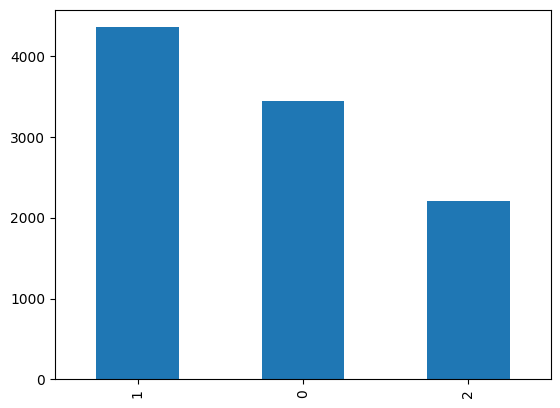

In [16]:
# update category values from -1, 0, 1 to 0,1, 2
tp.update_label_values()
tp.dataset.category.value_counts().plot(kind='bar')

In [17]:
# tp.text_processing(cols=('clean_text',))
tp.create_text_length(col='clean_text')

#### plot the distribution of text length and we can say a max_length = 270 would be suffice.

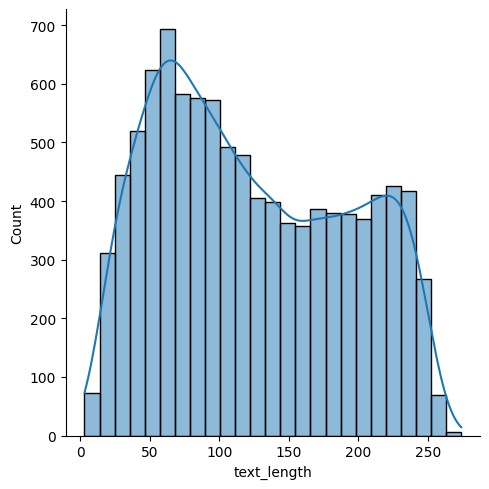

In [18]:
# plot the text length ditribution
sns.displot(tp.dataset.text_length, kde=True, bins=25)

In [19]:
# preprocessing data and split train and test datasets
# X_train_padded, X_test_padded = tp.data_preprcoessing()
tp.text_processing('clean_text')

### 4. Load the pretrained model and prepare tensor dataset for training

In [20]:
model_id="bert-base-uncased"
tokenizer = BertTokenizerFast.from_pretrained(model_id)
# tokenizer = AutoTokenizer.from_pretrained(model_id)
max_length = tp.dataset.text_length.max()
batch_size = 8

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:88: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/28.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

In [21]:
train_ds, val_ds, test_ds = tp.data_preprocessing(tokenizer, max_length=max_length, batch_size=batch_size)

### 5. Modelling using TFBertForSequenceClassification

In [22]:
# Define your custom id2label mapping
original_config = BertConfig.from_pretrained(model_id,
                                             id2label=tp.id2labels,
                                             label2id=tp.labels2id)
pretrained_model=TFBertForSequenceClassification.from_pretrained(model_id, config=original_config)
# Freeze all layers except the last layers for fine-tuning
for layer in pretrained_model.layers[:-2]:
    layer.trainable = False

# pretrained_model.trainable = False
# The output layer is accessible through the model's classifier attribute
output_layer = pretrained_model.classifier
print(output_layer)
# You can inspect the details of the output layer
pretrained_model.summary()

model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

All PyTorch model weights were used when initializing TFBertForSequenceClassification.

Some weights or buffers of the TF 2.0 model TFBertForSequenceClassification were not initialized from the PyTorch model and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Model: "tf_bert_for_sequence_classification"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 bert (TFBertMainLayer)      multiple                  109482240 
                                                                 
 dropout_37 (Dropout)        multiple                  0         
                                                                 
 classifier (Dense)          multiple                  2307      
                                                                 
Total params: 109484547 (417.65 MB)
Trainable params: 2307 (9.01 KB)
Non-trainable params: 109482240 (417.64 MB)
_________________________________________________________________


In [23]:
custom_model = SentimentAnalysisModel(pretrained_model=pretrained_model, units=3)

### 6. Training

In [24]:
num_epochs = 1000
batches_per_epoch = len(tp.train_dataset) // batch_size
total_train_steps = int(batches_per_epoch * num_epochs)

### 7. compile the model

In [34]:
learning_rate = 3e-5
custom_model.compile(optimizer=keras.optimizers.legacy.Adam(learning_rate=learning_rate),
              loss=keras.losses.SparseCategoricalCrossentropy(),
              metrics=['accuracy'])

In [35]:
# print(custom_model.config)

model_config = custom_model.get_config()
print(model_config)

{'units': 3}


### 8. train the model

In [36]:
# print(pretrained_model.config)

In [37]:
# training the model with training dataset and validate with validation dataset
# file_path = '/content/drive/MyDrive/colab/sentiment-analysis/data/models/check_points/'
file_path = 'data/models/check_points/'
!mkdir -p $file_path
history=custom_model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=num_epochs,
    callbacks=[
        CustomCheckpoint(filepath=file_path,
                         monitor='val_loss',
                         save_best_only=True,
                         save_weights_only=False,
                         verbose=2
                         ),
        PrintEpochProgress(),
        EarlyStoppingAtMinLoss(monitor='val_loss', patience=5,
                                restore_best_weights=True, mode='auto',
                                verbose=2),
    ],
    shuffle=True,
    verbose=2,
    )

Epoch 1/1000

Epoch: 1  Loss: 0.942858099937439
1013/1013 - 99s - loss: 0.9429 - accuracy: 0.5494 - val_loss: 0.9360 - val_accuracy: 0.5433 - 99s/epoch - 97ms/step
Epoch 2/1000

Epoch: 2  Loss: 0.9416452646255493
1013/1013 - 71s - loss: 0.9416 - accuracy: 0.5506 - val_loss: 0.9375 - val_accuracy: 0.5433 - 71s/epoch - 70ms/step
Epoch 3/1000

Epoch: 3  Loss: 0.944564163684845
1013/1013 - 70s - loss: 0.9446 - accuracy: 0.5489 - val_loss: 0.9386 - val_accuracy: 0.5422 - 70s/epoch - 70ms/step
Epoch 4/1000

Epoch: 4  Loss: 0.9368231892585754
1013/1013 - 71s - loss: 0.9368 - accuracy: 0.5525 - val_loss: 0.9178 - val_accuracy: 0.5533 - 71s/epoch - 70ms/step
Epoch 5/1000

Epoch: 5  Loss: 0.9361568093299866
1013/1013 - 76s - loss: 0.9362 - accuracy: 0.5543 - val_loss: 0.9405 - val_accuracy: 0.5367 - 76s/epoch - 75ms/step
Epoch 6/1000

Epoch: 6  Loss: 0.9358121752738953
1013/1013 - 71s - loss: 0.9358 - accuracy: 0.5525 - val_loss: 0.9166 - val_accuracy: 0.5544 - 71s/epoch - 70ms/step
Epoch 7/1000

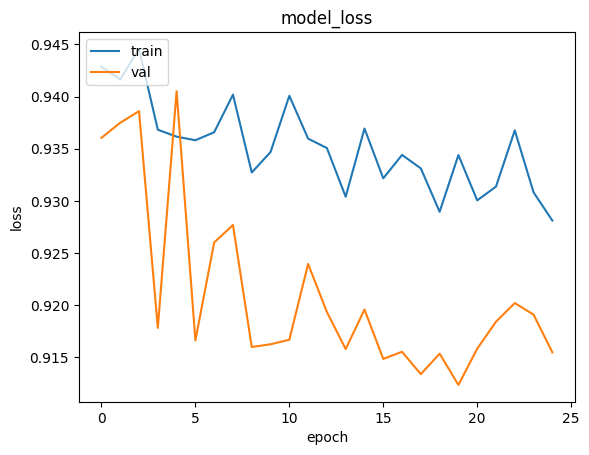

In [38]:
PlotDiagram.display_training_loss(history=history)

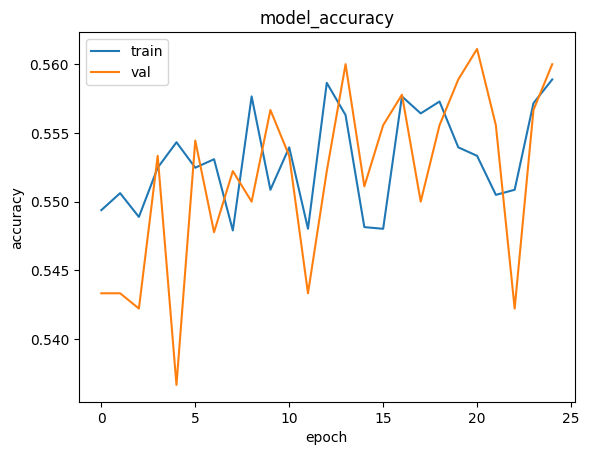

In [40]:
PlotDiagram.display_training_accuracy(history=history)

In [41]:
custom_model.summary()

Model: "sentiment_analysis_model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential (Sequential)     multiple                  109482240 
                                                                 
 lstm (LSTM)                 multiple                  459264    
                                                                 
 batch_normalization (Batch  multiple                  512       
 Normalization)                                                  
                                                                 
 dropout_38 (Dropout)        multiple                  0         
                                                                 
 bidirectional (Bidirection  multiple                  98816     
 al)                                                             
                                                                 
 batch_normalization_1 (Bat  multiple     

### 9. evaluate the mode

In [43]:
# trainer.evaluate()
test_loss = custom_model.evaluate(test_ds,
                               verbose=2,
                               sample_weight=None, )
print(f'evaluation loss: {test_loss}')

125/125 - 6s - loss: 0.9242 - accuracy: 0.5660 - 6s/epoch - 48ms/step
evaluation loss: [0.9241522550582886, 0.5659999847412109]


In [44]:
y_test_hat = custom_model.predict(test_ds)

125/125 [==============================] - 10s 54ms/step


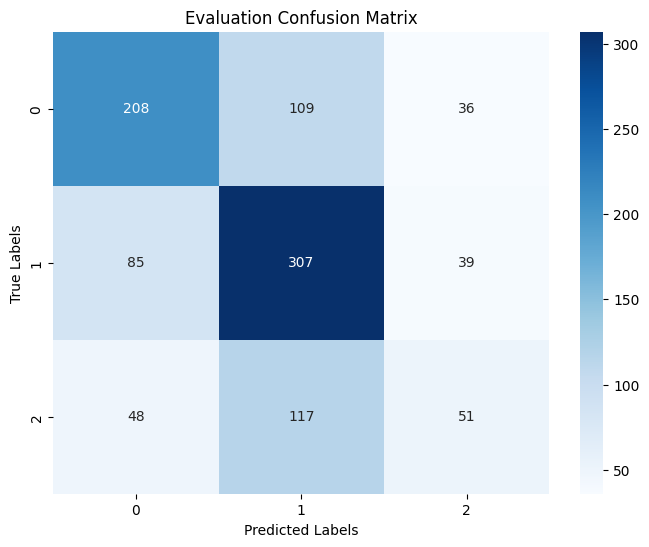

In [45]:
PlotDiagram.display_confusion_matrix(y_test=tp.test_dataset.category, y_test_hat=y_test_hat)

### 9. make predictions

In [47]:
inputs = ["this movie looks very interesting, i love the fact that the actors do a great job in showing how people lived in the 18th century, which wasn't very good at all. But atleast this movie recreates this scenes! ",
                    "very good start, but movie started becoming uninteresting at some point though initially i thought it would have been much more fun. There was too much background noise, but later on towards the middle of the movie, my favorite character got in and he did a great job, so over "]
tokenized_inputs = tp.prepare_predict_inputs(inputs, tokenizer=tokenizer, batch_size=batch_size, max_length=max_length)
predicted = custom_model.predict(tokenized_inputs)
print(predicted)

print(np.argmax(predicted, axis=1))

1/1 [==============================] - 0s 46ms/step
[[0.14620185 0.677392   0.17640619]
 [0.0682294  0.75488836 0.17688227]]
[1 1]
